In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


![openAI](https://openai.com/assets/images/home/openai-homepage@2x-4e2e39cbd1.svg)
Founded with the aim to build a safe artificial general intelligence, OpenAI have developed the Gym platform. This is a collection of environments and problems designed to flex the muscles of reinforcement learning algorithms. 

Let's get our gym membership...

In [2]:
import numpy as np
import gym
import random
import math

You're just off the phone to  Uber, they're having a bit of trouble with their new self driving car and they want you to fix it.

"No worries, Dara Khosrowshahi, I've got this under control!", *click*.

There are **`4`** locations represented by different letters and it's your job to pick up the passenger at one location and drop them off in another.

Let's load up our first environment `Taxi-v2`. 

In [3]:
env = gym.make("Taxi-v2")

We can view the state of our environment by using `render`.

In [4]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Now we can see our environment!
* Yellow square represents the taxi
* “|” represents a wall
* The letter coloured blue represents the passenger pick-up location
* The letter coloured purple represents the passengers destination 

**Note** The taxi will turn green when a passenger has been picked up.

There are six possible moves a taxi can take:
* Up `0`
* Down `1`
* Right `2`
* Left `3`
* Pickup `4`
* Dropoff `5`

Let's see a movement in action

In [5]:
# Pick a random state and render it
env.env.s = 420
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Let's move to the right by taking a `step`

In [6]:
# Remember right corresponds to 2
env.step(2)
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


See, we've moved a space to the right. 

Let's look a bit more closely at the output of `step`

In [7]:
env.step(2)

(440, -1, False, {'prob': 1.0})

These should be unpacked like this...

In [8]:
state, reward, done, info = env.step(2)
print('state: {}'.format(state))
print('reward: {}'.format(reward))
print('done: {}'.format(done))
print('info: {}'.format(info))

state: 440
reward: -1
done: False
info: {'prob': 1.0}


These outputs are the 'bread and butter' of reinforcement learning
* state- Current situation of the agent in the environment
* reward- Feedback from an action by the agent in the environment
* done- Boolean indicating whether the agent has terminated or completed its environment
* info- Diagnositic information about the agents last action. 


You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

Reward is kind of easy to misinterpret, it's normally a positive, however, in reinforcement learning it can either a positive or a negative.

**Positive**
* The agent receives `+20` points for a successful drop off

**Negative**
* The agent receives `-10` points for each mistake it makes when picking up or dropping off a passenger
* The agent receives `-1` point for every step it makes.


*Every breath you take*

*Every move you make*

*Every bond you break*

*Every step you take*

*I'll be <s>watching</s> rewarding you (with -1) *

The reason why we give a negative reward at each turn, it basically forces the agent to find the quickest possible solution.

Now what?

Well we have the agent, environment and rewards. Lets explore.

When we build any machine learning model we want to start simple. 

We know our objective is to pick up and drive our passenger to their destination, let's pick random actions until we get it right.

Use ` env.action_space.sample()` to take random actions until you have a successful trip.

**Tip** Think how a successful trip is rewarded.


In [9]:
state = env.reset()
reward = None
steps = 0

while reward != 20:
    state, reward, done, info = env.step(env.action_space.sample())
    steps += 1

print('Random driving took {} steps to complete a journey'.format(steps))

Random driving took 3768 steps to complete a journey


Run it a few more times and see how long it takes.

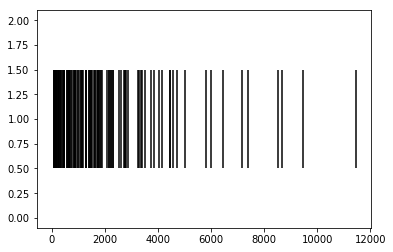

Average number of steps for a random drive 2177.6666666666665


In [10]:
random_driving_store = []
for i in range(1,100):
    state = env.reset()
    reward = None
    steps = 0

    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())
        steps += 1

    random_driving_store.append(steps)
    
from matplotlib import pyplot as plt
import numpy as np

plt.figure()
plt.hlines(0.5,0.5,2)  # Draw a horizontal line
plt.eventplot(random_driving_store, orientation='horizontal', colors='k')

plt.show()
print('Average number of steps for a random drive {}'.format(np.mean(random_driving_store)))

No surprises here, asigning a random action will get our taxi nowhere fast.

We need a way for our agent to learn how to manouver the mean streets of the gym. Lets try building a `Q-table`.

Think of a Q-table initially as a blank map of the environment. Your agent will navigate the space and updates the table with anything it finds interesting.

With each iteration the agent gets more and more information about the environment. In no time at all, your agent is whizzing around the environment.

Your map has now become a cheatsheet!

The Q-table is made up of rows equal to the number of `states` and columns equal to the number of `actions`.

The value at cell indicates the expected reward for an action given that state.

Let's build our Q-table...

In [11]:
state_size = env.observation_space.n
action_size = env.action_space.n

print('number of possible states: {}'.format(state_size))
print('number of possible actions: {}'.format(action_size))

number of possible states: 500
number of possible actions: 6


We've now got the dimensions of our Q-table, let's initialize our Q-table as a blank canvas (all zeros)

In [12]:
Q = np.zeros([state_size, action_size])
Q

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

Now we have the empty table, we get our agent to update it with information.

The Q-learning algorithm Process:
![process](https://cdn-images-1.medium.com/max/1600/1*QeoQEqWYYPs1P8yUwyaJVQ.png)

1. Initialize the Q table 
 * Done
2. Choose an action
 * Pick an action `a` in the agents current state `s` based selection criteria of Q-value estimates
3. Perform action
 * Perform the action chosen
4. Measure reward
 * Given the action taken `a` what is the new observed outcome state `s’` and reward `r`
 5. Update Q 
  * Use Bellman equation to update Q-table... 
 
![bellman](https://cdn-images-1.medium.com/max/2600/1*jmcVWHHbzCxDc-irBy9JTw.png) 






ummmmm sorry, what?

The Bellman equation is an optimization technique used in dynamic programming. It aims to find the greatest value between a decision at the current state and a new state. By breaking the dynamic optimization problem into a set of smaller problems it makes the overarchng problem easier to solve.


We will now code up this Q-learning process to build our optimized Q-table.


In [13]:
total_reward = 0
learning_rate = 0.7

We will start with a single episode, ie the episode completes when the agent fails or completes the trip.

In [14]:
done = False
total_reward, reward = 0,0
state = env.reset()
while done != True: # Keeps making actions until episode completes
        action = np.argmax(Q[state]) # Finds the action with the greatest reward. TIP each state is a row in the Q-table, find the best action at this state by finding the max value
        new_state, reward, done, info = env.step(action) #Takes the action with the greatest reward
        Q[state, action] += learning_rate * (reward + np.max(Q[new_state]) - Q[state, action]) # Updates our Q-table based on the state and actions. TIP If your stuck have a look at this pseudo code below
        total_reward += reward # Update our total reward
        state = new_state # Update our current state
#         env.render() # Print the current agent-environment interaction
print('Total reward for this episode: {}'.format(total_reward))


# New Q value = Current Q value + learning rate * (Reward + (maximum value of new state) — Current Q value )

Total reward for this episode: -542


Now we've built the logic, it's time to learn and build our Q-table across episodes. This will be easy, we'll stick our previous code in a `for loop` and iterate through `2000 episodes`

In [15]:
Q = np.zeros([state_size, action_size])

total_reward = 0
learning_rate = 0.7

for episode in range(1,2001):
    done = False
    total_reward, reward = 0,0
    state = env.reset()
    while done != True:
        action = np.argmax(Q[state])
        new_state, reward, done, info = env.step(action)
        Q[state, action] += learning_rate * (reward + np.max(Q[new_state]) - Q[state, action])
        total_reward += reward
        state = new_state   
    if episode % 50 == 0:
        print('Episode {} Total Reward: {}'.format(episode, total_reward))

Episode 50 Total Reward: -160
Episode 100 Total Reward: -98
Episode 150 Total Reward: -171
Episode 200 Total Reward: 7
Episode 250 Total Reward: -13
Episode 300 Total Reward: -43
Episode 350 Total Reward: 7
Episode 400 Total Reward: -5
Episode 450 Total Reward: 5
Episode 500 Total Reward: 7
Episode 550 Total Reward: 11
Episode 600 Total Reward: 11
Episode 650 Total Reward: 12
Episode 700 Total Reward: 10
Episode 750 Total Reward: 12
Episode 800 Total Reward: 11
Episode 850 Total Reward: 11
Episode 900 Total Reward: -14
Episode 950 Total Reward: 11
Episode 1000 Total Reward: 10
Episode 1050 Total Reward: 3
Episode 1100 Total Reward: 0
Episode 1150 Total Reward: 6
Episode 1200 Total Reward: 10
Episode 1250 Total Reward: 7
Episode 1300 Total Reward: 9
Episode 1350 Total Reward: 7
Episode 1400 Total Reward: 11
Episode 1450 Total Reward: 12
Episode 1500 Total Reward: 12
Episode 1550 Total Reward: 9
Episode 1600 Total Reward: 9
Episode 1650 Total Reward: 13
Episode 1700 Total Reward: 8
Episo

# Multi armed bandits

In the last exercise we were playing with taxis in a highly sterile environment. What we're going to do now is apply a reinforcement learning technique known as a multi armed bandit in a business case scenario.

The name multi armed bandit comes from a type of slot machine. You pull the lever, bleep bloop and either the machine pays out some money, or it doesn't.

You're faced with 6 slot machines with different probabilities of a payout. If you knew which one had the highest likelihood of a payout you would just stick with that one, right? 
The aim of a multi armed bandit is find the action with the greatest amount of reward, while still earning reward during this exploration phase.

This method of determining probability distrobutions while exploiting the most successful can be used in a huge variety of industries.
* **Clinical trials**- Exploration is akin to identifying an optimum treatment, while the exploitation occurs when treating patients efficiently as rapidly as possible from when the trial begins.
* **Game design**- Creating and experimenting with variants of a game mechanic, more players will be allocated to the variant with the greater level of success, thus ensuring maximized user interaction throughout the experiment.

However, the most used application of a multi armed bandit is as a turbo charged A/B test for product and advertising.

A/B testing is by far the most common way to gage user preference. The main problem of traditional A/B tests is that it is split into two separate stages exploration and **then** exploitation. 

Wheras multi armed bandits combine both these phases, ie gives you the ability to earn a reward whilst still trying to find the optimum action.

The goal of this next exercise to optimize the performance of your companies display ads. You make money everytime a user interacts with the ad. Your collegue has whipped up 10 variations of the ad, let's see if we can find the highest performing variant!



![Multi-armed-bandit](https://conversionxl.com/wp-content/uploads/2015/09/multiarmedbandit.jpg)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

We're going to have to do a bit of pretending here, the data we will be working with is a static file (not streamed data). Each row represents a user and each column represents the advert that user had seen. If the user clicked the ad, the cell has a value of 1, else it's 0.

In [17]:
# Importing the dataset ../input/ad-datacsv/Ads_Optimisation.csv
dataset = pd.read_csv('../input/ad-datacsv/Ads_Optimisation.csv')
print('First user clicked Ad 1, 5 and 9')
dataset.head(1)

First user clicked Ad 1, 5 and 9


,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0


Just like the last exercise it's best practice to start benchmarking with an agent taking random actions.

Let's start with assigning users to a random advert.

In [18]:
number_of_users = 10000
number_of_ads = 10
ads_selected = []
total_reward = 0
for user in range(0, number_of_users):
    ad_picked = random.randrange(number_of_ads)
    ads_selected.append(ad_picked)
    reward = dataset.values[user, ad_picked]
    total_reward = total_reward + reward

The results are in from the random assignment. 

In [19]:
total_reward

1302

In [20]:
pd.Series(ads_selected).value_counts(normalize=True)

7    0.1043
0    0.1028
3    0.1024
2    0.1001
6    0.0991
5    0.0988
4    0.0987
8    0.0987
9    0.0984
1    0.0967
dtype: float64

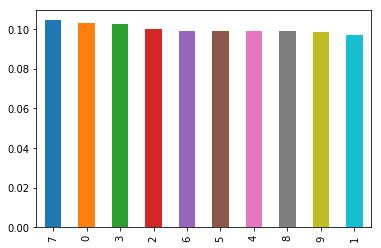

In [21]:
pd.Series(ads_selected).value_counts(normalize=True).plot(kind='bar')

A good multi arm bandit with clever user assignment should give us a clear winner. As you can see from our results, there is no clear winner.

Total reward for the random selection algorithm comes out to be ~1000. 

As this algorithm is not learning anything, it has no intuition into which ad is giving the maximum return. Therefore we would expect out of 10000 users it only gets ~1000, basically, a 1/10 chance, which makes sense as there are only 10 ads to choose from.

Random!

There must be a better way to optimize this problem...





Please enter Upper Confidence Bound (UCB)....

This is one of the most commonly used optimization processes for multi armed bandits. The main point to grasp about this algorithm is that the less familiar the bandit is with a particular action, the more curious it becomes, and in turn increases the chance to explore said action.

Check out the graph below.
![dist](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/09/im_18.jpg)


We can see the distribution of three different adverts above. You notice that a1 is much more spread out that either a2 or a3. This high level of spread indicates that this advert has not been explored enough. Next iteration the bandit will make a1 its top priority for exploration. It will keep doing this until the spread of that adverts reward meets a desired threshold.


Here's a bit of pseudo code to help you understand the algorithm a bit more clearly

Step 1. Run each of the adverts once, this will give us an ititial idea of the reward landscape
Step 2. For each iteration of t
Step 3. Count number of times each ad was shown so far (Nt(a))
Step 4. Plug values into the following expression
![formula](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/09/im_19.jpg)

Step 5. Calculate and store the reward

If this seems a bit too complicated don't worry, it was for me. I've grabbed some code that will help us. Try and follow along...

In [22]:
def UCB_multi_armed_bandit(number_of_users, number_of_ads, dataset):

    ads_selected = []
    numbers_of_selections = [0] * number_of_ads
    sums_of_reward = [0] * number_of_ads
    total_reward = 0

    for user in range(0, number_of_users):
        ad = 0
        max_upper_bound = 0
        for i in range(0, number_of_ads):
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                delta_i = math.sqrt(2 * math.log(user+1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                ad = i
        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = dataset.values[user, ad]
        sums_of_reward[ad] += reward
        total_reward += reward
    return ads_selected, total_reward

In [23]:
ads_selected, total_rewards = UCB_multi_armed_bandit(10000, 10, dataset)

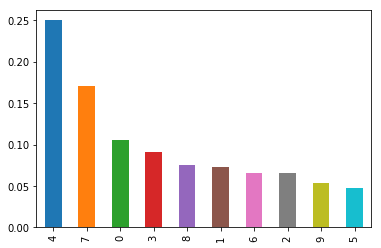

In [24]:
pd.Series(ads_selected).head(1500).value_counts(normalize=True).plot(kind='bar')

In [25]:
total_rewards

2125

Check that out! The total reward is much greater now and from the graph we have an ad that is clearly outperforming the rest, ad 5! (remember zero indexing is a thing in python). 

Since we had the the entire dataset from the start, we can check to see which ad did in fact have the highest click rate.

In [26]:
dataset.sum()/len(dataset)

Ad 1     0.1703
Ad 2     0.1295
Ad 3     0.0728
Ad 4     0.1196
Ad 5     0.2695
Ad 6     0.0126
Ad 7     0.1112
Ad 8     0.2091
Ad 9     0.0952
Ad 10    0.0489
dtype: float64

There we go! Our bandit was correct. Ad 5 was the top performer.

That's the main content complete for this months meetup. If you have time why don't you check out the extra exercises.

# Extra content

# Greedy epsilon algorithm
Here's another algorithm for learning `greedy epsilon`. Have a go with this code and try tweaking the hyperpara****meter

In [27]:
total_episodes = 20000        # Total episodes
total_test_episodes = 100     # Total test episodes
max_steps = 99                # Max steps per episode

learning_rate = 0.7           # Learning rate
gamma = 0.618                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.01             # Exponential decay rate for exploration prob


qtable = np.zeros((state_size, action_size))

In [28]:

# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 5.41525
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.03101391  -1.47220892  -1.93861517  -1.44879596  -0.72512948
  -10.50307739]
 [ -2.21044815   0.43833691  -0.73701282   0.37239713   2.33782249
   -8.57973158]
 ...
 [ -1.94631341   5.39966688  -1.94631341  -1.87956996  -9.1
   -7.        ]
 [ -2.41325649  -1.45834677  -2.35377987  -2.3753849  -10.95675082
  -10.79630496]
 [ 18.21933513   9.64128245  17.83968317  31.35602094   9.37443907
    8.87911438]]


In [29]:
env.reset()

for episode in range(5):
    state = env.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            env.render()
            
            # We print the number of step it took.
            print("Number of steps", step)
            break
        state = new_state
env.close()

****************************************************
EPISODE  0
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Number of steps 12
****************************************************
EPISODE  1
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Number of steps 13
****************************************************
EPISODE  2
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Number of steps 8
****************************************************
EPISODE  3
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Number of steps 12
****************************************************
EPISODE  4
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Number of steps 15


# Start exploring the frozen lake environment
OpenAI give us pleanty more environments to choose from. Check out the Frozen lake environment here


In [30]:
env = gym.make('FrozenLake-v0')

# Or check out any of these

In [31]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v2), EnvSpec(BipedalWalkerHardcore-v2), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v2), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(Hopper-v2), EnvSpec(Swimmer-v2), EnvSpec(Walker2d-v2), EnvSpec(Ant-v2), EnvSpec(Hum